# FID

In [ ]:
import pickle,gzip,math,os,time,shutil,torch,random
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

In [ ]:
from fastcore.test import test_close
from torch import distributions

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Train classifier

In [ ]:
xl,yl = 'image','label'
name = "fashion_mnist"
bs = 1024
xmean,xstd = 0.28,0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)) for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), MixedPrecision()]

In [ ]:
set_seed(42)
epochs = 5

In [ ]:
from timm import models

In [ ]:
lr = 4e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = models.resnet10t(in_chans=1, num_classes=10)
opt_func = partial(optim.AdamW, eps=1e-5)
learn = Learner(model, dls, F.cross_entropy, lr=lr, cbs=cbs, opt_func=opt_func)

accuracy,loss,epoch,train
0.791,0.592,0,train
0.593,2.560,0,eval
0.876,0.335,1,train
0.740,0.751,1,eval
0.905,0.255,2,train
0.896,0.290,2,eval
0.925,0.198,3,train
0.914,0.239,3,eval
0.943,0.153,4,train
0.921,0.218,4,eval


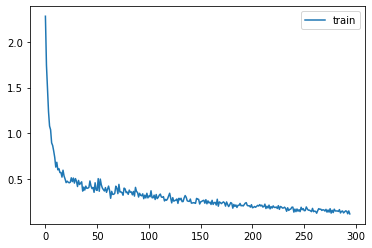

In [ ]:
learn.fit(epochs, cbs=xtra)

In [ ]:
mdl_path = Path('models')

In [ ]:
# torch.save(learn.model.state_dict(), mdl_path/'fashion_rn10t.sd')

In [ ]:
learn.model.load_state_dict(torch.load(mdl_path/'fashion_rn10t.sd'))

<All keys matched successfully>

In [ ]:
b = next(iter(dls.train))

In [ ]:
class Features(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.m=m
    def forward(self, x): return self.m.forward_features(x).squeeze()

clearn = TrainLearner(Features(model), DataLoaders([],[b]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats,y = clearn.capture_preds()
feats.shape,y

(torch.Size([1024, 512]), tensor([9, 0, 0,  ..., 4, 2, 7]))

In [ ]:
def append_outp(hook, mod, inp, outp):
    if not hasattr(hook,'outp'): hook.outp = []
    hook.outp.append(to_cpu(outp))

In [ ]:
hcb = HooksCallback(append_outp, mods=[learn.model.global_pool], on_valid=True)

In [ ]:
learn.fit(1, train=False, cbs=[hcb])

accuracy,loss,epoch,train
0.921,0.218,0,eval


In [ ]:
feats = hcb.hooks[0].outp[0].float()[:64]
feats.shape

torch.Size([64, 512])

In [ ]:
model.reset_classifier(0)
feats,y = learn.capture_preds()
feats = feats.float()
feats.shape,y

accuracy,loss,epoch,train
0.000,6.441,0,eval


(torch.Size([10000, 512]), tensor([9, 2, 1,  ..., 8, 1, 5]))

## Calc FID

In [ ]:
@inplace
def transformi(b): b[xl] = [TF.resize(TF.to_tensor(o), (32,32)) for o in b[xl]]

bs = 512
tds = dsd.with_transform(transformi)

In [ ]:
betamin,betamax,n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
from diffusers import UNet2DModel

class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample

In [ ]:
smodel = torch.load(mdl_path/'fashion_ddpm_mp.pkl').cuda()

In [ ]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.cpu().clamp(0,1))
    return preds

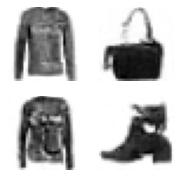

In [ ]:
samples = sample(smodel, (64, 1, 32, 32), alpha, alphabar, sigma, n_steps)
show_images(samples[-1][:4], imsize=1.5)

In [ ]:
clearn = TrainLearner(model, DataLoaders([],[(samples[-1],b[1])]), loss_func=fc.noop, cbs=[DeviceCB()], opt_func=None)
feats2,y2 = clearn.capture_preds()
feats2 = feats2.squeeze()
feats2.shape

torch.Size([64, 512])

In [ ]:
means = feats.mean(0)
means.shape

torch.Size([512])

In [ ]:
covs = feats.T.cov()
covs.shape

torch.Size([512, 512])

In [ ]:
from scipy import linalg

In [ ]:
def _calc_fid(feats1, feats2, eps=1e-6):
    m1,m2 = feats1.mean(0),feats2.mean(0)
    c1,c2 = feats1.T.cov(),feats2.T.cov()
    csr = tensor(linalg.sqrtm(c1@c2).real)
    return (((m1-m2)**2).sum() + c1.trace() + c2.trace() - 2*csr.trace()).item()

In [ ]:
_calc_fid(feats, feats2)

28.796219987385598

## FID class

In [ ]:
#|export
class FID:
    def __init__(self, model, dls, cbs=None):
        self.learn = TrainLearner(model, dls, loss_func=fc.noop, cbs=cbs, opt_func=None)
        self.feats = self.learn.capture_preds()[0].float().cpu()

    def __call__(self, samp):
        self.learn.dls = DataLoaders([],[(samp, tensor([0]))])
        feats2 = self.learn.capture_preds()[0].float().cpu()
        return _calc_fid(self.feats, feats2)

In [ ]:
fid = FID(model, learn.dls, cbs=[DeviceCB()])

In [ ]:
fid(samples[-1])

28.797954465536264

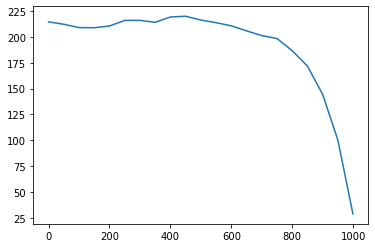

In [ ]:
xs = L.range(0,1000,50)+[999]
plt.plot(xs, [fid(samples[i]) for i in xs]);

## Inception

In [ ]:
from pytorch_fid.inception import InceptionV3

In [ ]:
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
imodel = InceptionV3(resize_input=False)

In [ ]:
learn.model = imodel

In [ ]:
a,y = learn.capture_preds()

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1024, 1, 28, 28] to have 3 channels, but got 1 channels instead

### Export -

In [ ]:
import nbdev; nbdev.nbdev_export()